# Objective

- Illustrate how RAG responses could be improved with self-reflection.
- Introduce how `langgraph` could be used to compose LLM execution graphs.

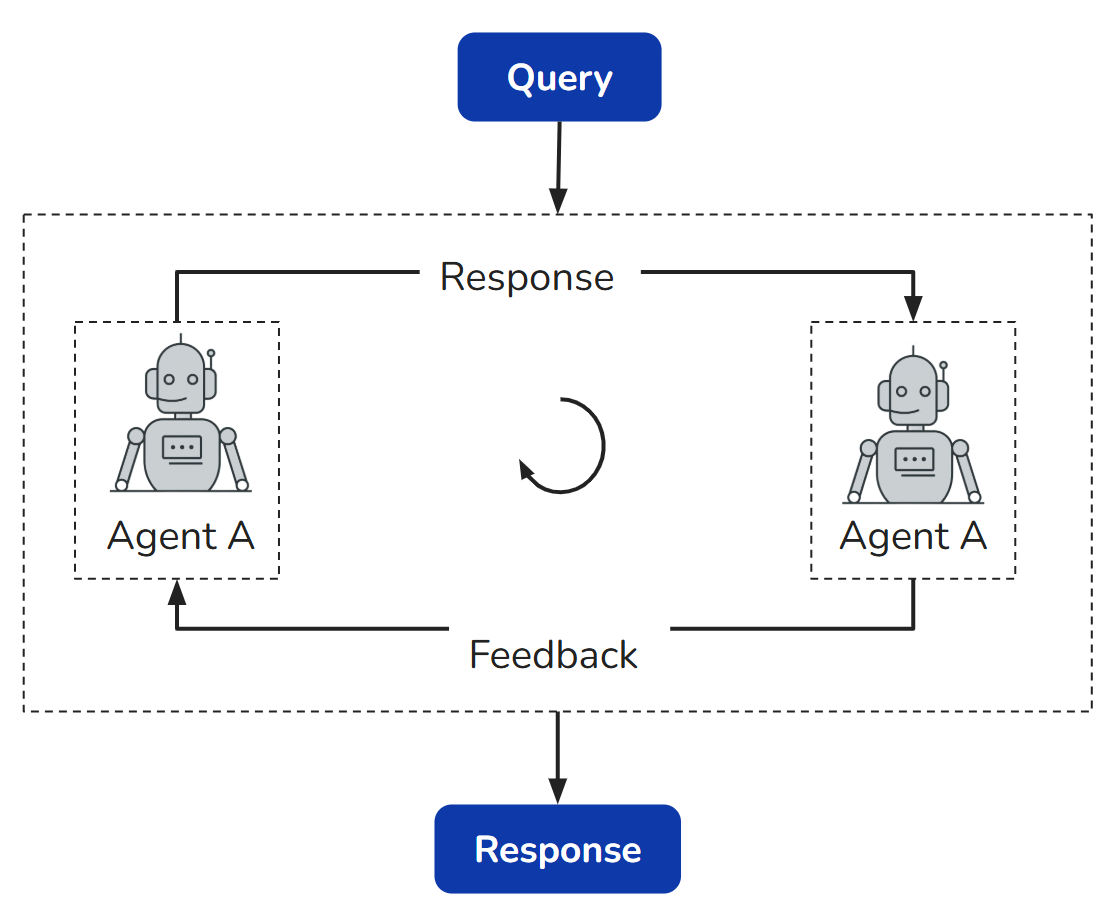

# Setup

## Installation

In [1]:
! pip install -q openai==1.55.3 \
                 langchain==0.3.7 \
                 langchain-openai==0.2.9 \
                 langgraph==0.2.52

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.8 MB/s eta 0:00:00


## Imports

In [2]:
import json

from langchain_openai import AzureChatOpenAI
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from typing import Annotated, List, Sequence
from typing_extensions import TypedDict

from IPython.display import Image, display

In [3]:
with open('config-azure.json') as f:
    configs = f.read()

In [4]:
creds = json.loads(configs)

In [5]:
llm = AzureChatOpenAI(
    azure_endpoint=creds['AZURE_OPENAI_ENDPOINT'],
    api_key=creds['AZURE_OPENAI_KEY'],
    api_version="2024-02-01",
    model="gpt-4o-mini",
    temperature=0
)

# Business Context

A banking institution wants to implement a robust RAG system that gives accurate, high quality answers to questions from their analysts rooted on financial documents.

In this notebook, we implement a RAG agent that utilizes self-reflection to progressively improve its answer.

To ensure that our focus is on the pattern of self-reflection, we will assume that the appropriate context for a user question is already retrieved from a vector database. This context is presented below.

In [6]:
financial_statement_context_data = """
Overview and 2023 Highlights
Our mission is to accelerate the world's transition to sustainable energy. We design, develop, manufacture, lease and sell high-performance fully electric vehicles, solar energy generation systems and energy storage products. We also offer maintenance, installation, operation, charging, insurance, financial and other services related to our products. Additionally, we are increasingly focused on products and services based on artificial intelligence, robotics and automation.
In 2023, we produced 1,845,985 consumer vehicles and delivered 1,808,581 consumer vehicles. We are currently focused on increasing vehicle production, capacity and delivery capabilities, reducing costs, improving and developing our vehicles and battery technologies, vertically integrating and localizing our supply chain, improving and further deploying our FSD capabilities, increasing the affordability and efficiency of our vehicles, bringing new products to market and expanding our global infrastructure, including our service and charging infrastructure.
In 2023, we deployed 14.72 GWh of energy storage products and 223 megawatts of solar energy systems. We are currently focused on ramping production of energy storage products, improving our Solar Roof installation capability and efficiency, and increasing market share of retrofit solar energy systems.
In 2023, we recognized total revenues of $96.77 billion, representing an increase of $15.31 billion, compared to the prior year. We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products, and invest in research and development to accelerate our AI, software and fleet-based profits for further revenue growth.
In 2023, our net income attributable to common stockholders was $15.00 billion, representing a favorable change of $2.44 billion, compared to the prior year. This included a one-time non-cash tax benefit of $5.93 billion for the release of valuation allowance on certain deferred tax assets. We continue to focus on further cost reductions and operational efficiencies while maximizing delivery volumes.
We ended 2023 with $29.09 billion in cash and cash equivalents and investments, representing an increase of $6.91 billion from the end of 2022. Our cash flows provided by operating activities in 2023 and 2022 were $13.26 billion and $14.72 billion, respectively, representing a decrease of $1.47 billion. Capital expenditures amounted to $8.90 billion in 2023, compared to $7.16 billion in 2022, representing an increase of $1.74 billion. Sustained growth has allowed our business to generally fund itself, and we will continue investing in a number of capital-intensive projects and research and development in upcoming periods.

We are focused on growing our manufacturing capacity, which includes capacity for manufacturing new vehicle models such as our Cybertruck and next generation platform, and ramping all of our production vehicles to their installed production capacities as well as increasing production rate and efficiency at our current factories. The next phase of production growth will depend on the continued ramp at our factories and the introduction of our next generation platform, as well as our ability to add to our available sources of battery cell supply by manufacturing our own cells that we are developing to have high-volume output, lower capital and production costs and longer range. Our goals are to improve vehicle performance, decrease production costs and increase affordability and customer awareness.
These plans are subject to uncertainties inherent in establishing and ramping manufacturing operations, which may be exacerbated by new product and manufacturing technologies we introduce, the number of concurrent international projects, any industry-wide component constraints, labor shortages and any future impact from events outside of our control. For example, during the third quarter of 2023, we experienced a sequential decline in production volumes due to pre-planned shutdowns for upgrades at various factories. Moreover, we have set ambitious technological targets with our plans for battery cells as well as for iterative manufacturing and design improvements for our vehicles with each new factory.
Automotive—Demand, Sales, Deliveries and Infrastructure
Our cost reduction efforts, cost innovation strategies, and additional localized procurement and manufacturing are key to our vehicles’ affordability and have allowed us to competitively price our vehicles. We will also continue to generate demand and brand awareness by improving our vehicles’ performance and functionality, including through products based on artificial intelligence such as Autopilot, FSD Capability, and other software features and delivering new vehicles, such as our Cybertruck. Moreover, we expect to continue to benefit from ongoing electrification of the automotive sector and increasing environmental regulations and initiatives.
However, we operate in a cyclical industry that is sensitive to political and regulatory uncertainty, including with respect to trade and the environment, all of which can be compounded by inflationary pressures, rising energy prices, interest rate fluctuations and the liquidity of enterprise customers. For example, inflationary pressures have increased across the markets in which we operate. In an effort to curb this trend, central banks in developed countries raised interest rates rapidly and substantially, impacting the affordability of vehicle lease and finance arrangements. Further, sales of vehicles in the automotive industry also tend to be cyclical in many markets, which may expose us to increased volatility as we expand and adjust our operations. Moreover, as additional competitors enter the marketplace and help bring the world closer to sustainable transportation, we will have to adjust and continue to execute well to maintain our momentum. Additionally, our suppliers’ liquidity and allocation plans may be affected by current challenges in the North American automotive industry, which could reduce our access to components or result in unfavorable changes to cost. These macroeconomic and industry trends have had, and will likely continue to have, an impact on the pricing of, and order rate for our vehicles, and in turn our operating margin. Changes in government and economic incentives in relation to electric vehicles may also impact our sales. We will continue to adjust accordingly to such developments, and we believe our ongoing cost reduction, including improved production innovation and efficiency at our newest factories and lower logistics costs, and focus on operating leverage will continue to benefit us in relation to our competitors, while our new products will help enable future growth.

As our production increases, we must work constantly to similarly increase vehicle delivery capability so that it does not become a bottleneck on our total deliveries. We are also committed to reducing the percentage of vehicles delivered in the third month of each quarter, which will help to reduce the cost per vehicle. As we expand our manufacturing operations globally, we will also have to continue to increase and staff our delivery, servicing and charging infrastructure accordingly, maintain our vehicle reliability and optimize our Supercharger locations to ensure cost effectiveness and customer satisfaction. In particular, as other automotive manufacturers have announced their adoption of the North American Charging Standard (“NACS”) and agreements with us to utilize our Superchargers, we must correspondingly expand our network in order to ensure adequate availability to meet customer demands. We also remain focused on continued enhancements of the capability and efficiency of our servicing operations.
Energy Generation and Storage Demand, Production and Deployment
The long-term success of this business is dependent upon increasing margins through greater volumes. We continue to increase the production of our energy storage products to meet high levels of demand, including the construction of a new Megafactory in Shanghai and the ongoing ramp at our Megafactory in Lathrop, California. For Megapack, energy storage deployments can vary meaningfully quarter to quarter depending on the timing of specific project milestones. We remain committed to growing our retrofit solar energy business by offering a low-cost and simplified online ordering experience. In addition, we continue to seek to improve our installation capabilities and price efficiencies for Solar Roof. As these product lines grow, we will have to maintain adequate battery cell supply for our energy storage products and ensure the availability of qualified personnel, particularly skilled electricians, to support the ramp of Solar Roof.
Cash Flow and Capital Expenditure Trends
Our capital expenditures are typically difficult to project beyond the short-term given the number and breadth of our core projects at any given time, and may further be impacted by uncertainties in future global market conditions. We are simultaneously ramping new products, building or ramping manufacturing facilities on three continents, piloting the development and manufacture of new battery cell technologies, expanding our Supercharger network and investing in autonomy and other artificial intelligence enabled training and products, and the pace of our capital spend may vary depending on overall priority among projects, the pace at which we meet milestones, production adjustments to and among our various products, increased capital efficiencies and the addition of new projects. Owing and subject to the foregoing as well as the pipeline of announced projects under development, all other continuing infrastructure growth and varying levels of inflation, we currently expect our capital expenditures to exceed $10.00 billion in 2024 and be between $8.00 to $10.00 billion in each of the following two fiscal years.
Our business has been consistently generating cash flow from operations in excess of our level of capital spend, and with better working capital management resulting in shorter days sales outstanding than days payable outstanding, our sales growth is also generally facilitating positive cash generation. We have and will continue to utilize such cash flows, among other things, to do more vertical integration, expand our product roadmap and provide financing options to our customers. At the same time, we are likely to see heightened levels of capital expenditures during certain periods depending on the specific pace of our capital-intensive projects and other potential variables such as rising material prices and increases in supply chain and labor expenses resulting from changes in global trade conditions and labor availability. Overall, we expect our ability to be self-funding to continue as long as macroeconomic factors support current trends in our sales.
"""

Given this context, we will now implement self-reflection to answer the following user question.

In [7]:
question = "How are the company's efforts to increase capacity going to impact their bottomline?"

# Solution Implementation

## Generator

We begin by first setting up the generator using a standard RAG prompt (using `LangChain` abstractions). The prompt instructs the LLM to answer questions using only the context information. Since this is the reflection pattern, the LLM is also instructed to expect user feedback and revise answers accounting for the feedback.

The system message and the prompt for the generator can be composed like so:

In [8]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert analyst at a financial services firm who answers user queries on annual reports."
            " User input will have the context required by you to answer user questions."
            " This context will begin with the word: ###Context."
            " The context contains documents relevant to the user query."
            " User questions will begin with the word: ###Question."
            " Please answer user questions only using the context provided in the input."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

The above prompt has a placeholder for messages that will be presented by the user (`HumanMessage`) and includes the context and the question like so:

In [9]:
request = HumanMessage(
    content=f"""
    ###Context:
    {financial_statement_context_data}
    ---
    ###Question:
    {question}
    """
)

Now we can compose the generator as an amalgamation of the system message and the LLM like so.

In [10]:
generator = prompt | llm

We now invoke the generator using the user message composed earlier.

In [11]:
response = generator.invoke({'messages': [request]})

In [12]:
print(response.content)

The company's efforts to increase manufacturing capacity are aimed at ramping production of new vehicle models and enhancing the efficiency of current factories. By increasing production rates and reducing costs, these efforts are expected to improve vehicle performance and affordability, which can lead to higher sales volumes. 

In 2023, the company recognized total revenues of $96.77 billion, an increase from the previous year, and net income attributable to common stockholders was $15.00 billion, reflecting a favorable change. As the company continues to expand its operations and invest in research and development, it aims to accelerate revenue growth, which should positively impact the bottom line.

However, the company also faces uncertainties, such as potential production bottlenecks, macroeconomic factors, and industry-wide component constraints, which could affect profitability. Overall, if the company successfully increases its capacity and manages these challenges, it is like

The above output is the first attempt of the generator. Let us now assemble a reflector that will look at the output from the generator and provide pointed feedback to improve the answer.

## Reflector

We now implement a reflector using a system message that asks the LLM (the same LLM since this is self-reflection) to review the answer.

In [13]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert financial analyst rating an answer to a question. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including factual grounding, logic, coherence, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflector = reflection_prompt | llm

To invoke the reflector, we pass in the response that is received from the generator in the previous section.

In [14]:
reflection = reflector.invoke({'messages': [request, HumanMessage(content=response.content)]})

In [15]:
print(reflection.content)

### Critique of Submission

Your response provides a solid overview of how the company's efforts to increase manufacturing capacity could impact its bottom line. However, there are several areas where you could enhance your analysis to make it more comprehensive and insightful.

#### Strengths:
1. **Clear Structure**: Your answer is well-structured, beginning with the company's goals and moving into the potential impacts on revenue and net income.
2. **Use of Data**: You effectively reference the company's financial performance in 2023, which adds credibility to your analysis.

#### Areas for Improvement:
1. **Depth of Analysis**: While you mention the potential for increased sales volumes and improved operational efficiencies, you could delve deeper into how these factors specifically translate into bottom-line improvements. For instance, you could discuss the expected percentage increase in sales or how cost reductions might affect margins.
   
2. **Quantitative Projections**: Provid

As indicated in the above output, the reflector provided clear guidance on the strengths and recommends specific changes.

Now that we have built and tested the generator and reflector, we can now compose an execution graph that has these as key nodes and execution bounces back and forth between them.

## Self-Reflection as an Execution Graph

We now build an execution graph with control passed between the generator and the reflector. In `LangGraph`, this execution graph can be crystallized by passing the state of the graph between the generator and reflector defined as nodes in the graph.

In [16]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


async def generation_node(state: State) -> State:
    return {"messages": [await generator.ainvoke(state["messages"])]}


async def reflection_node(state: State) -> State:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    res = await reflector.ainvoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}

The above code defines two asynchronous functions `generation_node` and `reflection_node` that encapsulate the same logic that we tested out in the previous sections.

The `generation_node` simply invokes the LLM with the context and the user question. The `reflection_node` takes its output (AI output) and presents it as user feedback back to the generator. This necessitates a swap of `AIMessage` and `HumanMessage`.

Now that both the nodes are defined, we need to stitch them up into an execution graph. This is done by instatiating a `StateGraph` and adding the generator and reflector nodes to it liek so:

In [17]:
builder = StateGraph(State)
builder.add_node("generator", generation_node)
builder.add_node("reflector", reflection_node)
builder.add_edge(START, "generator")

As the above code indicates, we add two nodes - generator & reflector. Then we add an edge between the `START` node and the generator.

Instead of directly connecting the generator and the reflector with an edge, we implement a conditional edge that is triggered till three iterations of feedback are passes between the reflector and the generator.

The code below implements this logic.

In [18]:
def should_continue(state: State):
    if len(state["messages"]) > 6:
        # End after 3 iterations
        return END
    return "reflector"

builder.add_conditional_edges("generator", should_continue)
builder.add_edge("reflector", "generator")

With this graph now wired up, we can compile it and inspect its structure. Note that in `LangGraph` execution graphs need to be compiled before use.

In [19]:
graph = builder.compile()

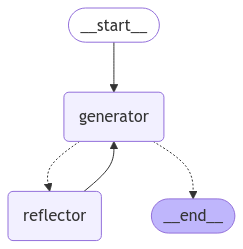

In [20]:
display(Image(graph.get_graph().draw_mermaid_png()))

We can now execute the above graph like so:

In [21]:
async for event in graph.astream(
    {
        "messages": [
            HumanMessage(
                content=f"""
                ###Context:
                {financial_statement_context_data}
                ---
                ###Question:
                {question}
                """
            )
        ]
    }
):
    print(event)
    print("---")

{'generator': {'messages': [AIMessage(content="The company's efforts to increase manufacturing capacity are expected to positively impact their bottom line in several ways. By ramping up production and improving vehicle delivery capabilities, the company aims to reduce costs and enhance operational efficiencies. This is crucial as increased production can lead to higher sales volumes, which in turn can boost revenues. \n\nAdditionally, the focus on vertical integration and localizing the supply chain is intended to lower production costs, making vehicles more affordable and competitive in the market. The introduction of new vehicle models, such as the Cybertruck, and advancements in battery technologies are also expected to drive demand and improve margins.\n\nFurthermore, as the company expands its global infrastructure, including service and charging capabilities, it can enhance customer satisfaction and potentially increase sales. Overall, these efforts are aligned with the company'

The final answer after 3 rounds of reflection can be extracted like so.

In [22]:
print(event['generator']['messages'][0].content)

Thank you for your encouraging feedback and final recommendations. Here’s a further refined version of my response, incorporating your suggestions for additional depth and clarity:

---

The company's efforts to increase manufacturing capacity are expected to have a significant positive impact on its bottom line through several interconnected factors:

1. **Increased Production and Sales Volume**: By ramping up production capabilities, the company aims to enhance its delivery capacity, which is crucial for meeting growing consumer demand. For instance, in 2023, the company produced 1,845,985 consumer vehicles, and projections suggest that with increased capacity, production could exceed 2 million vehicles in the coming years. This increase in production is likely to lead to higher sales volumes, directly contributing to revenue growth.

2. **Cost Reductions through Vertical Integration**: The company is focusing on vertically integrating its supply chain, which is expected to lower pro